# Раздел 1. EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# # # Эта ячейка запускается в случае подкачки данных с личного Google Drive
# # #  при работе в Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Путь к экселевскому файлу нужно настроить в соответствии
# с фактическим местонахождением данных
# xlsx_df_path = "/content/drive/MyDrive/drafts/hack_12_2025/Обращения.xlsx"
xlsx_df_path = "Обращения.xlsx"

In [4]:
# Читаем данные и выводим общую информацию
df = pd.read_excel(xlsx_df_path)
display(df.head())
display(df.info())

,Дата обращения,Описание,Тема обращения,Идентификатор устройства
0,2025-10-10T07:52:33+03:00[Europe/Moscow],Здравствуйте! Квартира по адресу: Ул. Гризодуб...,Запрос портала,177045
1,2025-09-22T10:47:27+03:00[Europe/Moscow],"По адресу Стрелецкая улица, дом 9, корпус 2 пр...",Запрос портала,86874
2,2025-09-05T17:44:29+03:00[Europe/Moscow],Не могут открыть дверь через приложение . Со с...,Приложение. Умные решения,11699
3,2025-09-06T12:55:35+03:00[Europe/Moscow],Вадим хочет установить в квартире по адресу: <...,Приложение. Умные решения,51120
4,2025-10-17T08:09:09+03:00[Europe/Moscow],Не могу подключить управление домофона чтобы у...,Запрос портала,179157


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Дата обращения            2553 non-null   object
 1   Описание                  2552 non-null   object
 2   Тема обращения            2553 non-null   object
 3   Идентификатор устройства  2553 non-null   object
dtypes: object(4)
memory usage: 79.9+ KB


None

In [5]:
# Удаляем строку(строки) с пустым текстом обращения
df = df.dropna(subset='Описание')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2552 entries, 0 to 2552
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Дата обращения            2552 non-null   object
 1   Описание                  2552 non-null   object
 2   Тема обращения            2552 non-null   object
 3   Идентификатор устройства  2552 non-null   object
dtypes: object(4)
memory usage: 99.7+ KB


None

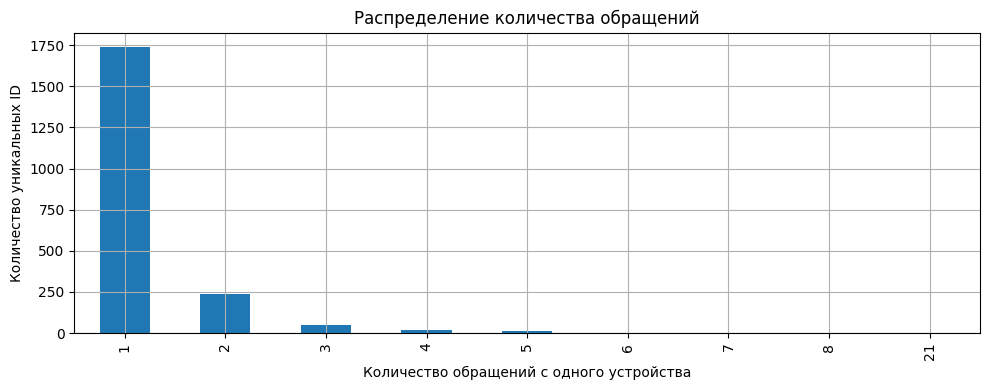

In [7]:
# Проанализируем распределение - сколько заходов
# с уникальных устройств имеется в базе

# Считаем количество вхождений каждого ID
id_counts = df[
    'Идентификатор устройства'
    ].value_counts().value_counts().sort_index()

# Строим bar chart
plt.figure(figsize=(10, 4))
id_counts.plot(kind='bar')
plt.xlabel('Количество обращений с одного устройства')
plt.ylabel('Количество уникальных ID')
plt.title('Распределение количества обращений')
plt.tight_layout()
plt.grid()
plt.show()

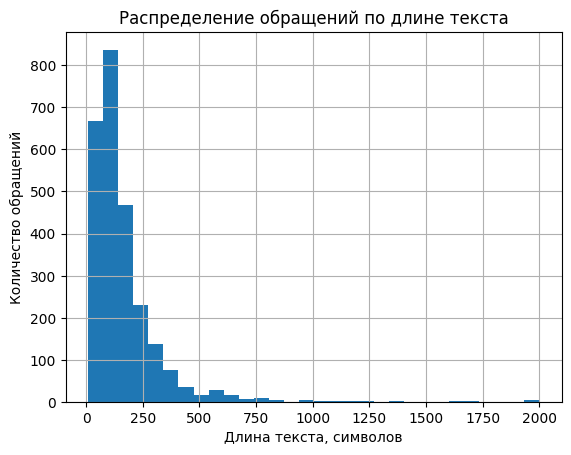

In [8]:
# Проанализируем распределение длины текстов
text_lengths = df['Описание'].apply(len)
text_lengths.hist(bins=30)
plt.title('Распределение обращений по длине текста')
plt.xlabel('Длина текста, символов')
plt.ylabel('Количество обращений')
plt.show()

# Раздел 2. Модель анализа тональности

### Подготовка к обучению модели
Если модель используется для inference, а не для обучения, этот раздел не нужен

In [9]:
import pandas as pd
from transformers import pipeline, AutoTokenizer
from datasets import Dataset, load_from_disk

In [2]:
# # Эта ячейка запускается в случае подкачки данных с личного Google Drive
# #  при работе в Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Пути к сохраненным обучающему, валидационному и тестовому датасету
# Эти датасеты размечены вручную
# При запуске со своими источниками данных требуется актуализировать адреса
train_path = "/content/drive/MyDrive/drafts/hack_12_2025/train_augmented.csv"
val_path = "/content/drive/MyDrive/drafts/hack_12_2025/val_marked.csv"
test_path = "/content/drive/MyDrive/drafts/hack_12_2025/test_marked.csv"

In [11]:
# Загружаем датасеты, смотрим, что они корректно открылись
df_train = pd.read_csv(train_path)
display(df_train.head())
df_val = pd.read_csv(val_path)
display(df_val.head())
df_test = pd.read_csv(test_path)
display(df_test.head())

,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-01T10:05:13+03:00[Europe/Moscow],"Добрый день, можно ли открыть доступ на коррек...",Запрос портала,1592,0,0
1,2025-09-30T08:59:55+03:00[Europe/Moscow],Не отправляется заявка на чуть тёплые батареи,Запрос портала,26340,1,2
2,2025-09-16T16:48:19+03:00[Europe/Moscow],Прошу отменить ОСС № 1363950 (Маршала Бирюзова...,Запрос портала,100549,0,0
3,2025-10-28T08:41:10+03:00[Europe/Moscow],Почему закрыли мою заявку \n04805702/25\nВообщ...,Запрос портала,93123,2,2
4,2025-10-05T15:43:26+03:00[Europe/Moscow],При вводе данных адреса постоянно ошибку выдаё...,Запрос портала,114028,1,2


,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-22T14:10:15+03:00[Europe/Moscow],В подъездах домов размещено объявление о прове...,Запрос портала,38907,0,1
1,2025-09-25T10:29:32+03:00[Europe/Moscow],Присылайте ежедневный результат по опросу,Запрос портала,109710,0,0
2,2025-10-16T09:17:14+03:00[Europe/Moscow],при попытке ввести код плательщика возникает о...,Запрос портала,130194,0,2
3,2025-10-07T08:30:27+03:00[Europe/Moscow],Не работает освещение в коридоре между квартир...,Запрос портала,87198,0,2
4,2025-10-13T17:54:58+03:00[Europe/Moscow],Хочу отозвать свой голос. Прошу не учитывать ...,Запрос портала,21452,0,0


,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-24T10:10:12+03:00[Europe/Moscow],Добрый день. \nСтанислав Мартынов больше не яв...,Запрос портала,10588,0,2
1,2025-09-21T11:09:44+03:00[Europe/Moscow],На подъезде объявление о опросе об установке у...,Запрос портала,149876,0,2
2,2025-10-26T13:17:41+03:00[Europe/Moscow],Не вижу кнопки проголосовать,Запрос портала,91012,0,2
3,2025-09-22T16:25:37+03:00[Europe/Moscow],Я являюсь собственником квартиры по адресу:ул....,Запрос портала,34532,0,0
4,2025-09-23T17:30:13+03:00[Europe/Moscow],Тема: Re: Запрос #13280348 Запрос портала\n ...,Запрос портала,127735,0,2


In [12]:
# Преобразование в формат HuggingFace Dataset
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

# Проверка
print(f"Train dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")
print(f"Validation dataset: {test_dataset}")

Train dataset: Dataset({
    features: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Уровень недовольства', 'Заявка-Вопрос-Жалоба'],
    num_rows: 589
})
Validation dataset: Dataset({
    features: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Уровень недовольства', 'Заявка-Вопрос-Жалоба'],
    num_rows: 150
})
Validation dataset: Dataset({
    features: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Уровень недовольства', 'Заявка-Вопрос-Жалоба'],
    num_rows: 150
})


In [13]:
# Загрузка токенизатора для rubert-tiny2
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Токенизатор загружен")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Токенизатор загружен


In [14]:
# Функция для токенизации
def tokenize_function(examples):
    result = tokenizer(
        examples['Описание'],
        truncation=True,
        padding='max_length',
        max_length=512
    )
    return result

In [15]:
# Помечаем на удаление всё, кроме колонки с таргетом

columns_to_remove = [col for col in train_dataset.column_names
                     if col != 'Уровень недовольства'
                     ]
print(f"На удаление колонки: {columns_to_remove}")

На удаление колонки: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Заявка-Вопрос-Жалоба']


In [16]:
val_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/val_tokenized"
)

# Токенизация валидационного датасета
val_dataset_tokenized = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=columns_to_remove
)
# Переименовываем метку в 'labels'
val_dataset_tokenized = val_dataset_tokenized.rename_column(
    'Уровень недовольства', 'labels'
    )
print("Токенизация завершена")
print(f"Val tokenized: {val_dataset_tokenized}")
val_dataset_tokenized.save_to_disk(val_tokenized_path)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Токенизация завершена
Val tokenized: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})


Saving the dataset (0/1 shards):   0%|          | 0/150 [00:00<?, ? examples/s]

In [17]:
train_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/train_tokenized"
)

# Токенизация тренировочного датасета
train_dataset_tokenized = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=columns_to_remove
)
# Переименовываем метку в 'labels'
train_dataset_tokenized = train_dataset_tokenized.rename_column(
    'Уровень недовольства', 'labels'
    )
print("Токенизация завершена")
print(f"Train tokenized: {train_dataset_tokenized}")
train_dataset_tokenized.save_to_disk(train_tokenized_path)

Map:   0%|          | 0/589 [00:00<?, ? examples/s]

Токенизация завершена
Train tokenized: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 589
})


Saving the dataset (0/1 shards):   0%|          | 0/589 [00:00<?, ? examples/s]

In [18]:
test_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/test_tokenized"
)

# Токенизация тестового датасета
test_dataset_tokenized = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=columns_to_remove
)
# Переименовываем метку в 'labels'
test_dataset_tokenized = test_dataset_tokenized.rename_column(
    'Уровень недовольства', 'labels'
    )
print("Токенизация завершена")
print(f"Test tokenized: {test_dataset_tokenized}")
test_dataset_tokenized.save_to_disk(test_tokenized_path)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Токенизация завершена
Test tokenized: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})


Saving the dataset (0/1 shards):   0%|          | 0/150 [00:00<?, ? examples/s]

### Этап обучения модели
(лучше на GPU, но можно медленно и на CPU)

In [19]:
from transformers import (AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer,
                          AutoTokenizer,
                          pipeline
)
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import torch

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Загрузка сохраненных токенизированных данных

train_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/train_tokenized"
)
val_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/val_tokenized"
)
test_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/test_tokenized"
)

train_dataset_tokenized = load_from_disk(train_tokenized_path)
val_dataset_tokenized = load_from_disk(val_tokenized_path)
test_dataset_tokenized = load_from_disk(test_tokenized_path)

print("Загруженные датасеты:")
print(f"Train: {train_dataset_tokenized}")
print(f"Validation: {val_dataset_tokenized}")
print(f"Test: {test_dataset_tokenized}")

Загруженные датасеты:
Train: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 589
})
Validation: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})
Test: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})


In [21]:
model_name = "cointegrated/rubert-tiny2"
# Загружаем токенизатор для той же модели, что будем дообучать
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Проверяем, что токенизатор загружен правильно
print(f"Токенизатор загружен: {tokenizer.__class__.__name__}")
print(f"Размер словаря: {tokenizer.vocab_size}")

Токенизатор загружен: BertTokenizerFast
Размер словаря: 83828


In [22]:
# Функция для токенизации
def tokenize_function(examples):
    result = tokenizer(
        examples['Описание'],
        truncation=True,
        padding='max_length',
        max_length=512
    )
    return result

In [23]:
# Так как датасет сильно несбалансированный,
# стандартные функции потерь не работают.
# Создаем функцию потерь, которая будет присваивать больший вес
#  ошибкам на слабо представленных категориях
labels = train_dataset_tokenized['labels']
class_weights = compute_class_weight('balanced',
                                     classes=np.array([0, 1, 2]),
                                     y=labels
                                     )
class_weights = torch.tensor(class_weights, dtype=torch.float)

# создаем кастомный Trainer с кастомной функцией потерь
class WeightedTrainer(Trainer):
    def compute_loss(self,
                    model,
                    inputs,
                    return_outputs=False,
                    num_items_in_batch=None
                    ):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
            )
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels),
            labels.view(-1)
            )
        return (loss, outputs) if return_outputs else loss

In [24]:
# Загружаем модель для классификации на 3 класса
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label={0: "neutral", 1: "frustration", 2: "aggression"},
    label2id={"neutral": 0, "frustration": 1, "aggression": 2}
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Параметры обучения (пути при необходимости актуализировать)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/drafts/hack_12_2025/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/drafts/hack_12_2025/logs',
    logging_steps=10,
    load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
    # greater_is_better=False,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    save_total_limit=3,
    push_to_hub=False,
    gradient_accumulation_steps=2
)

In [26]:
# Функция для вычисления метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Вычисляем accuracy и F1-score (macro average)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')

    return {
        "accuracy": acc,
        "f1_macro": f1
    }

In [27]:
# Создаём trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=val_dataset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/tmp/ipython-input-3403610003.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
model_path = '/content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned'

In [ ]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.097900,1.057652,0.760000,0.417063
2,1.067700,1.037412,0.793333,0.434903
3,1.055500,1.031107,0.800000,0.446025


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned


In [ ]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.044200,0.995084,0.853333,0.635151
2,1.013800,0.976558,0.833333,0.589959
3,1.000000,0.970455,0.833333,0.571429


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned


In [ ]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.011800,0.959445,0.873333,0.583163
2,0.974600,0.942618,0.853333,0.557292
3,0.947400,0.936988,0.833333,0.540210


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned


In [ ]:
# запуск с последнего чекпойнта
training_args.num_train_epochs = 6
checkpoint_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/results/checkpoint-57"
)
print("Начинаем обучение...")
trainer.train(resume_from_checkpoint=checkpoint_path)

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
4,0.936200,0.926568,0.833333,0.537333
5,0.882800,0.908596,0.840000,0.524930
6,0.892100,0.906840,0.833333,0.519277


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned


In [ ]:
# Оценка на валидационном наборе
print("\nОценка на валидационном наборе:")
eval_results = trainer.evaluate()
print(f"Loss: {eval_results['eval_loss']:.4f}")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results['eval_f1_macro']:.4f}")


Оценка на валидационном наборе:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Loss: 0.9951
Accuracy: 0.8533
F1-macro: 0.6352


In [ ]:
# Загрузка модели и токенизатора
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Проверка загрузки
print(f"Модель загружена: {model.__class__.__name__}")
print(f"Количество классов: {model.num_labels}")
print(f"Идентификаторы классов: {model.config.id2label}")

Модель загружена: BertForSequenceClassification
Количество классов: 3
Идентификаторы классов: {0: 'neutral', 1: 'frustration', 2: 'aggression'}


### Проверка разных моделей

In [8]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset

# ================== КОНФИГУРАЦИЯ ==================
# Пути к моделям и чекпоинтам
model_paths = {
    # 'model_last': '/content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned',
    'model_previous': '/content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned_v1',
    # 'checkpoint_results_v1': "/content/drive/MyDrive/drafts/hack_12_2025/results_v1/checkpoint-57",
    'checkpoint_results_v2_1': "/content/drive/MyDrive/drafts/hack_12_2025/results_v2/checkpoint-19",
    'checkpoint_results_1': "/content/drive/MyDrive/drafts/hack_12_2025/results/checkpoint-95"
}

# Пути к данным
train_path = "/content/drive/MyDrive/drafts/hack_12_2025/train_augmented.csv"
# val_path = "/content/drive/MyDrive/drafts/hack_12_2025/val_marked.csv"
# test_path = "/content/drive/MyDrive/drafts/hack_12_2025/test_marked.csv"

train_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/train_tokenized"
)
# val_tokenized_path = (
#     "/content/drive/MyDrive/drafts/hack_12_2025/val_tokenized"
# )
# test_tokenized_path = (
#     "/content/drive/MyDrive/drafts/hack_12_2025/test_tokenized"
# )

# val_dataset_path = '/path/to/val_tokenized'
# test_dataset_path = '/path/to/test_tokenized'  # если есть
# val_texts_path = '/path/to/val_texts.csv'  # CSV с исходными текстами

val_dataset_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/val_tokenized"
)
test_dataset_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/test_tokenized"
)
val_texts_path = "/content/drive/MyDrive/drafts/hack_12_2025/val_marked.csv"
# val_path = "/content/drive/MyDrive/drafts/hack_12_2025/val_marked.csv"
test_path = "/content/drive/MyDrive/drafts/hack_12_2025/test_marked.csv"

In [9]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_texts_path)
display(df_val.head())
df_test = pd.read_csv(test_path)
display(df_test.head())
train_texts = df_train['Описание'].tolist()
val_texts = df_val['Описание'].tolist()
test_texts = df_test['Описание'].tolist()

,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-22T14:10:15+03:00[Europe/Moscow],В подъездах домов размещено объявление о прове...,Запрос портала,38907,0,1
1,2025-09-25T10:29:32+03:00[Europe/Moscow],Присылайте ежедневный результат по опросу,Запрос портала,109710,0,0
2,2025-10-16T09:17:14+03:00[Europe/Moscow],при попытке ввести код плательщика возникает о...,Запрос портала,130194,0,2
3,2025-10-07T08:30:27+03:00[Europe/Moscow],Не работает освещение в коридоре между квартир...,Запрос портала,87198,0,2
4,2025-10-13T17:54:58+03:00[Europe/Moscow],Хочу отозвать свой голос. Прошу не учитывать ...,Запрос портала,21452,0,0


,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-24T10:10:12+03:00[Europe/Moscow],Добрый день. \nСтанислав Мартынов больше не яв...,Запрос портала,10588,0,2
1,2025-09-21T11:09:44+03:00[Europe/Moscow],На подъезде объявление о опросе об установке у...,Запрос портала,149876,0,2
2,2025-10-26T13:17:41+03:00[Europe/Moscow],Не вижу кнопки проголосовать,Запрос портала,91012,0,2
3,2025-09-22T16:25:37+03:00[Europe/Moscow],Я являюсь собственником квартиры по адресу:ул....,Запрос портала,34532,0,0
4,2025-09-23T17:30:13+03:00[Europe/Moscow],Тема: Re: Запрос #13280348 Запрос портала\n ...,Запрос портала,127735,0,2


In [10]:

# ================== ФУНКЦИИ ==================

def load_model_and_tokenizer(model_path):
    """Загрузка модели и токенизатора"""
    print(f"Загрузка модели: {model_path}")
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

def get_predictions(trainer, dataset):
    """Использовать готовый trainer для предсказаний"""
    predictions = trainer.predict(dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    return pred_labels, predictions.predictions

def evaluate_model(model_name,
                   trainer,
                   val_dataset,
                   val_texts=None,
                   test_dataset=None,
                   test_texts=None):
    """Полная оценка модели через Trainer"""
    print(f"\n{'='*60}")
    print(f"ОЦЕНКА МОДЕЛИ: {model_name}")
    print(f"{'='*60}")

    results = {'model_name': model_name}

    # 1. Валидационная выборка
    print("\n--- ВАЛИДАЦИОННАЯ ВЫБОРКА ---")

    # Получаем предсказания через trainer
    val_predictions = trainer.predict(val_dataset)
    val_preds = np.argmax(val_predictions.predictions, axis=1)
    val_labels = val_predictions.label_ids

    # Глобальные метрики
    results['val_accuracy'] = accuracy_score(val_labels, val_preds)
    results['val_f1_macro'] = f1_score(val_labels, val_preds, average='macro')
    results['val_f1_weighted'] = f1_score(val_labels, val_preds, average='weighted')

    print(f"Accuracy: {results['val_accuracy']:.4f}")
    print(f"F1-macro: {results['val_f1_macro']:.4f}")
    print(f"F1-weighted: {results['val_f1_weighted']:.4f}")

    # Подробный отчет по классам
    print("\nClassification Report:")
    report = classification_report(
        val_labels,
        val_preds,
        target_names=['Class 0', 'Class 1', 'Class 2'],
        output_dict=True,
        digits=4
    )

    for class_idx, class_name in enumerate(['Class 0', 'Class 1', 'Class 2']):
        results[f"val_{class_name.lower().replace(' ', '_')}_precision"] = report[class_name]['precision']
        results[f"val_{class_name.lower().replace(' ', '_')}_recall"] = report[class_name]['recall']
        results[f"val_{class_name.lower().replace(' ', '_')}_f1"] = report[class_name]['f1-score']
        results[f"val_class_{class_idx}_support"] = report[class_name]['support']

    print(classification_report(val_labels, val_preds, target_names=['Class 0', 'Class 1', 'Class 2']))

    # Матрица ошибок
    print("\nConfusion Matrix:")
    cm = confusion_matrix(val_labels, val_preds)
    print(cm)
    results['val_confusion_matrix'] = cm.tolist()

    # Примеры ошибок (первые 5)
    print("\nПримеры ошибок (первые 5):")
    error_indices = np.where(val_labels != val_preds)[0][:5]

    # Если есть тексты в датасете
    if val_texts:
        for i, idx in enumerate(error_indices):
            text = val_texts[idx]
            true_label = val_labels[idx]
            pred_label = val_preds[idx]
            print(f"\nОшибка {i+1}:")
            print(f"  True: {true_label}, Pred: {pred_label}")
            print(f"  Текст: {text[:150]}..." if len(text) > 150 else f"  Текст: {text}")

    # 2. Тестовая выборка (если есть)
    if test_dataset is not None:
        print("\n--- ТЕСТОВАЯ ВЫБОРКА ---")

        test_predictions = trainer.predict(test_dataset)
        test_preds = np.argmax(test_predictions.predictions, axis=1)
        test_labels = test_predictions.label_ids

        results['test_accuracy'] = accuracy_score(test_labels, test_preds)
        results['test_f1_macro'] = f1_score(test_labels, test_preds, average='macro')
        results['test_f1_weighted'] = f1_score(test_labels, test_preds, average='weighted')

        print(f"Accuracy: {results['test_accuracy']:.4f}")
        print(f"F1-macro: {results['test_f1_macro']:.4f}")
        print(f"F1-weighted: {results['test_f1_weighted']:.4f}")

        test_report = classification_report(
            test_labels,
            test_preds,
            target_names=['Class 0', 'Class 1', 'Class 2'],
            output_dict=True,
            digits=4
        )

        for class_idx, class_name in enumerate(['Class 0', 'Class 1', 'Class 2']):
            results[f"test_{class_name.lower().replace(' ', '_')}_precision"] = test_report[class_name]['precision']
            results[f"test_{class_name.lower().replace(' ', '_')}_recall"] = test_report[class_name]['recall']
            results[f"test_{class_name.lower().replace(' ', '_')}_f1"] = test_report[class_name]['f1-score']
            results[f"test_class_{class_idx}_support"] = test_report[class_name]['support']

        print(classification_report(test_labels, test_preds, target_names=['Class 0', 'Class 1', 'Class 2']))

        test_cm = confusion_matrix(test_labels, test_preds)
        print("\nConfusion Matrix (test):")
        print(test_cm)
        results['test_confusion_matrix'] = test_cm.tolist()

        return results, val_preds, test_preds, val_labels, test_labels

    return results, val_preds, None, val_labels, None


def create_comparison_dataframe(val_dataset, all_predictions, all_labels, model_names):
    """Создание датафрейма с предсказаниями всех моделей"""
    # Базовый датафрейм
    df = pd.DataFrame({
        'true_label': all_labels[0] if len(all_labels) > 0 else val_dataset['labels']
    })

    # Добавляем тексты, если есть
    if 'Описание' in val_dataset.features:
        df['text'] = val_dataset['Описание']

    # Добавляем предсказания каждой модели
    for model_name, preds in zip(model_names, all_predictions):
        df[f'pred_{model_name}'] = preds

    # Анализ согласованности моделей
    pred_columns = [f'pred_{name}' for name in model_names]

    if len(pred_columns) > 1:
        df['models_agreement'] = df[pred_columns].nunique(axis=1)
        df['majority_vote'] = df[pred_columns].mode(axis=1)[0]

        # Определяем, где модели ошибаются (хотя бы одна)
        df['any_model_correct'] = df.apply(
            lambda row: any(row[f'pred_{name}'] == row['true_label'] for name in model_names),
            axis=1
        )

    return df

def analyze_errors(df, model_names, sample_size=5):
    """Анализ ошибок моделей"""
    print(f"\n{'='*60}")
    print("АНАЛИЗ ОШИБОК")
    print(f"{'='*60}")

    for model_name in model_names:
        pred_col = f'pred_{model_name}'
        errors = df[df['true_label'] != df[pred_col]]

        print(f"\nМодель: {model_name}")
        print(f"Всего ошибок: {len(errors)} ({len(errors)/len(df)*100:.1f}%)")

        if len(errors) > 0:
            # Типы ошибок
            print("\nТипы ошибок (true -> pred):")
            error_types = errors.groupby(['true_label', pred_col]).size()
            for (true, pred), count in error_types.items():
                print(f"  {true} -> {pred}: {count} примеров")

            # Примеры ошибок
            print(f"\nПримеры ошибок (первые {sample_size}):")
            sample_errors = errors.head(sample_size)
            for idx, row in sample_errors.iterrows():
                if 'text' in df.columns:
                    text_preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
                    print(f"  True: {row['true_label']}, Pred: {row[pred_col]}")
                    print(f"  Текст: {text_preview}")
                else:
                    print(f"  True: {row['true_label']}, Pred: {row[pred_col]}")
                print()

def plot_comparison(comparison_results):
    """Визуализация сравнения моделей"""
    # Создаем DataFrame с результатами
    df_results = pd.DataFrame(comparison_results)

    # График 1: Accuracy и F1-macro
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    ax1 = axes[0, 0]
    df_results.plot(x='model_name', y=['val_accuracy', 'test_accuracy'] if 'test_accuracy' in df_results.columns else ['val_accuracy'],
                    kind='bar', ax=ax1, title='Accuracy')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    # F1-macro
    ax2 = axes[0, 1]
    df_results.plot(x='model_name', y=['val_f1_macro', 'test_f1_macro'] if 'test_f1_macro' in df_results.columns else ['val_f1_macro'],
                    kind='bar', ax=ax2, title='F1-macro')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # Precision по классам
    ax3 = axes[1, 0]
    precision_cols = [col for col in df_results.columns if 'precision' in col and 'val' in col]
    df_results[precision_cols].plot(kind='bar', ax=ax3, title='Precision по классам (val)')
    ax3.set_xticklabels(df_results['model_name'], rotation=45)
    ax3.legend(['Class 0', 'Class 1', 'Class 2'])

    # Recall по классам
    ax4 = axes[1, 1]
    recall_cols = [col for col in df_results.columns if 'recall' in col and 'val' in col]
    df_results[recall_cols].plot(kind='bar', ax=ax4, title='Recall по классам (val)')
    ax4.set_xticklabels(df_results['model_name'], rotation=45)
    ax4.legend(['Class 0', 'Class 1', 'Class 2'])

    plt.tight_layout()
    plt.show()

    return df_results

In [ ]:
def main():
    val_dataset = val_dataset_tokenized
    test_dataset = test_dataset_tokenized

    # 2. Создание тренеров для каждой модели
    comparison_results = []
    all_val_predictions = []
    all_test_predictions = []
    all_val_labels = []
    all_test_labels = []
    model_names = []

    for model_name, model_path in model_paths.items():
        try:
            print(f"\nЗагрузка модели: {model_name}")

            # Загружаем модель и токенизатор
            model = AutoModelForSequenceClassification.from_pretrained(model_path)
            tokenizer = AutoTokenizer.from_pretrained(model_path)

            # Создаем тренера для этой модели
            trainer = WeightedTrainer(
                args=training_args,
                model=model,
                tokenizer=tokenizer,
                eval_dataset=val_dataset_tokenized,
                compute_metrics=compute_metrics

            # Оценка модели
            results, val_preds, test_preds, val_labs, test_labs = evaluate_model(
                model_name=model_name,
                trainer=trainer,
                val_dataset=val_dataset,
                val_texts=val_texts,  # список текстов
                test_dataset=test_dataset,
                test_texts=test_texts
                )

            comparison_results.append(results)
            all_val_predictions.append(val_preds)
            all_val_labels.append(val_labs)

            if test_preds is not None:
                all_test_predictions.append(test_preds)
                all_test_labels.append(test_labs)

            model_names.append(model_name)

        except Exception as e:
            print(f"Ошибка при оценке модели {model_name}: {e}")
            import traceback
            traceback.print_exc()

    # 3. Создание датафрейма сравнения
    print(f"\n{'='*60}")
    print("СВОДНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
    print(f"{'='*60}")

    # Датафрейм с предсказаниями на валидации
    comparison_df_val = create_comparison_dataframe(
        val_dataset,
        all_val_predictions,
        all_val_labels,
        model_names
    )
    comparison_df_test = create_comparison_dataframe(
        test_dataset,
        all_test_predictions,
        all_test_labels,
        model_names
    )

    # 4. Анализ ошибок
    analyze_errors(comparison_df_val, model_names)

    # 5. Сохранение результатов
    # Сводная таблица метрик
    metrics_df = pd.DataFrame(comparison_results)
    metrics_df.to_csv('model_comparison_metrics.csv', index=False)
    print(f"\nМетрики сохранены в model_comparison_metrics.csv")

    # Датафрейм с предсказаниями
    comparison_df_val.to_csv('model_predictions_comparison_val.csv', index=False)
    print(f"Предсказания сохранены в model_predictions_comparison_val.csv")
    comparison_df_test.to_csv('model_predictions_comparison_test.csv', index=False)
    print(f"Предсказания сохранены в model_predictions_comparison_test.csv")

    # 6. Вывод лучшей модели
    print(f"\n{'='*60}")
    print("ЛУЧШАЯ МОДЕЛЬ ПО F1-macro:")
    best_model = metrics_df.loc[metrics_df['val_f1_macro'].idxmax()]
    print(f"Модель: {best_model['model_name']}")
    print(f"F1-macro: {best_model['val_f1_macro']:.4f}")
    print(f"Accuracy: {best_model['val_accuracy']:.4f}")
    print(f"F1 по классам:")
    print(f"  Class 0: {best_model['val_class_0_f1']:.4f}")
    print(f"  Class 1: {best_model['val_class_1_f1']:.4f}")
    print(f"  Class 2: {best_model['val_class_2_f1']:.4f}")

    return comparison_df_val, metrics_df

# Запуск
if __name__ == "__main__":
    comparison_df, metrics_df = main()

### Сохранение моделей
(служебный раздел, выполнять не требуется)

In [ ]:
# model_paths = {
#     # 'model_last': '/content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned',
#     'model_previous': '/content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned_v1',
#     # 'checkpoint_results_v1': "/content/drive/MyDrive/drafts/hack_12_2025/results_v1/checkpoint-57",
#     'checkpoint_results_v2_1': "/content/drive/MyDrive/drafts/hack_12_2025/results_v2/checkpoint-19",
#     'checkpoint_results_1': "/content/drive/MyDrive/drafts/hack_12_2025/results/checkpoint-95"
# }

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
tokenizer_save_path = '/content/drive/MyDrive/drafts/hack_12_2025/models/tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

('/content/drive/MyDrive/drafts/hack_12_2025/models/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/drafts/hack_12_2025/models/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/drafts/hack_12_2025/models/tokenizer/vocab.txt',
 '/content/drive/MyDrive/drafts/hack_12_2025/models/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/drafts/hack_12_2025/models/tokenizer/tokenizer.json')

In [7]:
load_path = '/content/drive/MyDrive/drafts/hack_12_2025/logs/rubert_tiny2_finetuned_v1'
save_path = '/content/drive/MyDrive/drafts/hack_12_2025/models/model_previous'

In [10]:
load_path = '/content/drive/MyDrive/drafts/hack_12_2025/results_v2/checkpoint-19'
save_path = '/content/drive/MyDrive/drafts/hack_12_2025/models/checkpoint_results_v2_1'

In [12]:
load_path = '/content/drive/MyDrive/drafts/hack_12_2025/results/checkpoint-95'
save_path = '/content/drive/MyDrive/drafts/hack_12_2025/models/checkpoint_results_1'

In [13]:
model_to_save = AutoModelForSequenceClassification.from_pretrained(load_path)

model_to_save.save_pretrained(save_path)

### Предсказание на всем массиве данных

In [ ]:
# !pip install gdown

In [28]:
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# Скачивание публичной папки (лимит 50 файлов)
!gdown --folder "https://drive.google.com/drive/folders/17JbOwP2g7E-ZZSWn388QgEizjGxrc2Er?usp=sharing"

Retrieving folder contents
Retrieving folder 1gR6f58hUtM8AQAZ6mLIT2Ry4Rgo5gXhI checkpoint_results_1
Processing file 1q56gWazDGnqb_2b9aZ7fv8Q6YXO3djWJ config.json
Processing file 1b-tFvlS4HdocqxWKetkC4RqDw8HPepMQ model.safetensors
Retrieving folder 1j7YhhujD4yV7LQQfsFUS7e40T4JAARxB checkpoint_results_v2_1
Processing file 1_qrFfIp8FikwlZxPkEu0Y_msT2IGFfGG config.json
Processing file 1-GFjE0y66fHZ-z0jqNjghqhfWtaab3Rm model.safetensors
Retrieving folder 19f2F-PTturblnRH7IKbRnPaTgfB822eE model_2
Processing file 1WO4eyRB-QaN4SZDF2z8Hp9KfQ6xpO3wZ config.json
Processing file 1CC3nJHGuqo9sPOs4iDj6dmovbsoXpJ6C model.safetensors
Retrieving folder 1Vv3w8tAdClTJWoobCrDC84hVNOm3EcMa model_previous
Processing file 12iiO9AOIkgcIhJrM_OeCNRUZsHc2HDTD config.json
Processing file 1mD7RBUWasgoGdn329U5l5gwpknUMRzUg model.safetensors
Retrieving folder 1WuBxrZgbL-eTs9_v02deDBo_CX7PHOrf tokenizer
Processing file 1FmccIcehslcga7vAPLH2mForglIEvBzm special_tokens_map.json
Processing file 1WTUzQTq8TnCehBN4wtAOZkYJ

In [30]:
# Загрузка токенизатора
tokenizer_save_path = './models/tokenizer'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

In [31]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [32]:
# Загрузка моделей
model_paths = ['./models/model_previous',
               './models/checkpoint_results_v2_1',
               './models/checkpoint_results_1'
               ]
models = [
    AutoModelForSequenceClassification.from_pretrained(path).eval()
    for path in model_paths
]
if torch.cuda.is_available():
    models = [model.cuda() for model in models]

In [33]:
# Здесь идет инференс ансамбля моделей классификации
# на переданном списке текстов
def predict_in_bulk(texts):
    # df = pd.read_csv(df_path)
    # texts = df['Описание'].tolist()
    # Батчевая обработка
    dataloader = DataLoader(TextDataset(texts), batch_size=16)

    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(
                batch,
                truncation=True,
                padding='max_length',
                max_length=512,
                return_tensors='pt'
            )

            if torch.cuda.is_available():
                inputs = {k: v.cuda() for k, v in inputs.items()}

            batch_preds = []
            for model in models:
                outputs = model(**inputs)
                batch_preds.append(torch.argmax(outputs.logits, dim=1).cpu())

            sums = torch.stack(batch_preds, dim=1).sum(dim=1)
            all_preds.extend([
                0 if s <= 1 else 1 if s <= 3 else 2
                for s in sums
            ])
    return all_preds


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Здесь можено менять адрес датасета, и тогда модель обработает заданный файл
df_path = "/content/drive/MyDrive/drafts/hack_12_2025/обращения.csv"
df = pd.read_csv(df_path)
texts = df['Описание'].tolist()

In [12]:
# Сохраняем файл с предсказаниями модели
df['Уровень негатива'] = predict_in_bulk(texts)
df.to_csv('обращения_predict.csv',
          index=None
          )

### Расчет метрик

In [34]:
def show_metrics(y_true, y_pred):

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    print("Confusion Matrix:")
    print(cm)

    # Визуализация confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.show()

    # Подробный отчет с учетом дисбаланса
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=['0', '1', '2'],
        digits=3
        ))

    # Метрики с усреднением для дисбалансированных данных
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        average=None
        )
    macro_f1 = precision_recall_fscore_support(
        y_true,
        y_pred,
        average='macro'
        )[2]
    weighted_f1 = precision_recall_fscore_support(
        y_true,
        y_pred,
        average='weighted'
        )[2]

    print(f"\nMacro F1-score: {macro_f1:.3f}")
    print(f"Weighted F1-score: {weighted_f1:.3f}")

    # Дополнительно: метрики для каждого класса
    print("\nДетали по классам:")
    for i, label in enumerate([0, 1, 2]):
        print(
            f"Класс {label}: Precision={precision[i]:.3f},"
            + f"Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}"
            )

In [35]:
val_path = "/content/drive/MyDrive/drafts/hack_12_2025/val_marked.csv"
test_path = "/content/drive/MyDrive/drafts/hack_12_2025/test_marked.csv"
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)


Обзор метрик на валидационной выборке:

Confusion Matrix:
[[120   8   2]
 [  7   8   2]
 [  1   1   1]]


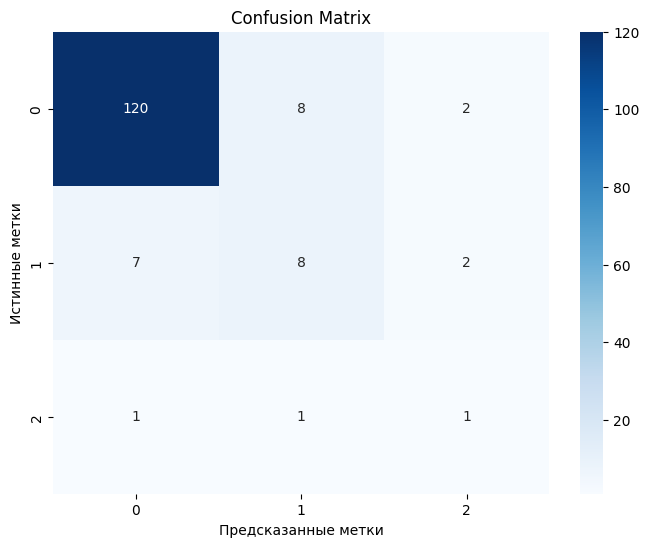


Classification Report:
              precision    recall  f1-score   support

           0      0.938     0.923     0.930       130
           1      0.471     0.471     0.471        17
           2      0.200     0.333     0.250         3

    accuracy                          0.860       150
   macro avg      0.536     0.576     0.550       150
weighted avg      0.870     0.860     0.865       150


Macro F1-score: 0.550
Weighted F1-score: 0.865

Детали по классам:
Класс 0: Precision=0.938,Recall=0.923, F1=0.930, Support=130
Класс 1: Precision=0.471,Recall=0.471, F1=0.471, Support=17
Класс 2: Precision=0.200,Recall=0.333, F1=0.250, Support=3


In [36]:
print('Обзор метрик на валидационной выборке:\n')
y_true = df_val['Уровень недовольства']
y_pred = predict_in_bulk(df_val['Описание'].tolist())
show_metrics(y_true, y_pred)

Обзор метрик на тестовой выборке:

Confusion Matrix:
[[108  12   3]
 [ 12   8   1]
 [  2   0   4]]


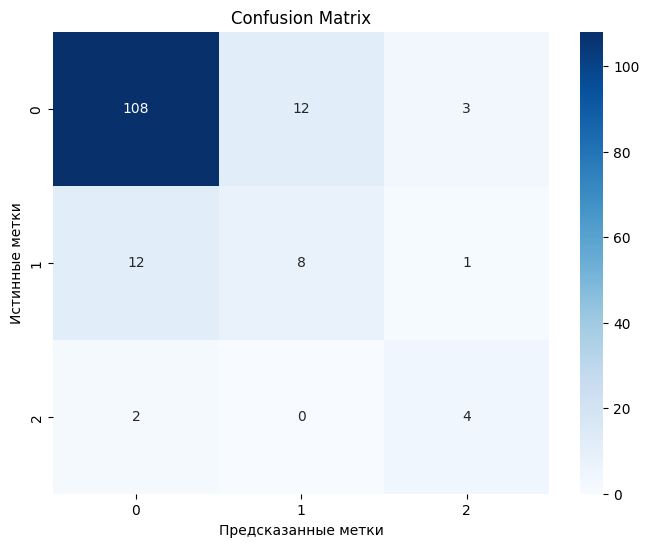


Classification Report:
              precision    recall  f1-score   support

           0      0.885     0.878     0.882       123
           1      0.400     0.381     0.390        21
           2      0.500     0.667     0.571         6

    accuracy                          0.800       150
   macro avg      0.595     0.642     0.614       150
weighted avg      0.802     0.800     0.800       150


Macro F1-score: 0.614
Weighted F1-score: 0.800

Детали по классам:
Класс 0: Precision=0.885,Recall=0.878, F1=0.882, Support=123
Класс 1: Precision=0.400,Recall=0.381, F1=0.390, Support=21
Класс 2: Precision=0.500,Recall=0.667, F1=0.571, Support=6


In [37]:
print('Обзор метрик на тестовой выборке:\n')
y_true = df_test['Уровень недовольства']
y_pred = predict_in_bulk(df_test['Описание'].tolist())
show_metrics(y_true, y_pred)

# Раздел 3. Модель классификации вида заявки

Подготовка и обучение аналогичны первой модели, но здесь другой таргет

In [1]:
import pandas as pd
from transformers import pipeline, AutoTokenizer
from datasets import Dataset, load_from_disk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = "/content/drive/MyDrive/drafts/hack_12_2025/train_augmented.csv"
val_path = "/content/drive/MyDrive/drafts/hack_12_2025/val_marked.csv"
test_path = "/content/drive/MyDrive/drafts/hack_12_2025/test_marked.csv"

In [4]:
df_train = pd.read_csv(train_path)
display(df_train.head())
df_val = pd.read_csv(val_path)
display(df_val.head())
df_test = pd.read_csv(test_path)
display(df_test.head())

,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-01T10:05:13+03:00[Europe/Moscow],"Добрый день, можно ли открыть доступ на коррек...",Запрос портала,1592,0,0
1,2025-09-30T08:59:55+03:00[Europe/Moscow],Не отправляется заявка на чуть тёплые батареи,Запрос портала,26340,1,2
2,2025-09-16T16:48:19+03:00[Europe/Moscow],Прошу отменить ОСС № 1363950 (Маршала Бирюзова...,Запрос портала,100549,0,0
3,2025-10-28T08:41:10+03:00[Europe/Moscow],Почему закрыли мою заявку \n04805702/25\nВообщ...,Запрос портала,93123,2,2
4,2025-10-05T15:43:26+03:00[Europe/Moscow],При вводе данных адреса постоянно ошибку выдаё...,Запрос портала,114028,1,2


,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-22T14:10:15+03:00[Europe/Moscow],В подъездах домов размещено объявление о прове...,Запрос портала,38907,0,1
1,2025-09-25T10:29:32+03:00[Europe/Moscow],Присылайте ежедневный результат по опросу,Запрос портала,109710,0,0
2,2025-10-16T09:17:14+03:00[Europe/Moscow],при попытке ввести код плательщика возникает о...,Запрос портала,130194,0,2
3,2025-10-07T08:30:27+03:00[Europe/Moscow],Не работает освещение в коридоре между квартир...,Запрос портала,87198,0,2
4,2025-10-13T17:54:58+03:00[Europe/Moscow],Хочу отозвать свой голос. Прошу не учитывать ...,Запрос портала,21452,0,0


,Дата обращения,Описание,Тема обращения,Идентификатор устройства,Уровень недовольства,Заявка-Вопрос-Жалоба
0,2025-09-24T10:10:12+03:00[Europe/Moscow],Добрый день. \nСтанислав Мартынов больше не яв...,Запрос портала,10588,0,2
1,2025-09-21T11:09:44+03:00[Europe/Moscow],На подъезде объявление о опросе об установке у...,Запрос портала,149876,0,2
2,2025-10-26T13:17:41+03:00[Europe/Moscow],Не вижу кнопки проголосовать,Запрос портала,91012,0,2
3,2025-09-22T16:25:37+03:00[Europe/Moscow],Я являюсь собственником квартиры по адресу:ул....,Запрос портала,34532,0,0
4,2025-09-23T17:30:13+03:00[Europe/Moscow],Тема: Re: Запрос #13280348 Запрос портала\n ...,Запрос портала,127735,0,2


In [5]:
# Преобразование в формат HuggingFace Dataset
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

# Проверка
print(f"Train dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")
print(f"Validation dataset: {test_dataset}")

Train dataset: Dataset({
    features: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Уровень недовольства', 'Заявка-Вопрос-Жалоба'],
    num_rows: 589
})
Validation dataset: Dataset({
    features: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Уровень недовольства', 'Заявка-Вопрос-Жалоба'],
    num_rows: 150
})
Validation dataset: Dataset({
    features: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Уровень недовольства', 'Заявка-Вопрос-Жалоба'],
    num_rows: 150
})


In [6]:
# Загрузка токенизатора для rubert-tiny2
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Токенизатор загружен")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Токенизатор загружен


In [7]:
# Функция для токенизации
def tokenize_function(examples):
    result = tokenizer(
        examples['Описание'],
        truncation=True,
        padding='max_length',
        max_length=512
    )
    return result

In [8]:
# Помечаем на удаление всё, кроме колонки с таргетом
# Таргет для модели 2 - другой столбец по сравнению с моделью 1

columns_to_remove = [col for col in train_dataset.column_names if col != 'Заявка-Вопрос-Жалоба']
print(f"На удаление колонки: {columns_to_remove}")

Удаляем колонки: ['Дата обращения', 'Описание', 'Тема обращения', 'Идентификатор устройства', 'Уровень недовольства']


In [9]:
val_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/val_tokenized2"
)

# Токенизация валидационного датасета
val_dataset_tokenized = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=columns_to_remove
)
# Переименовываем метку в 'labels'
val_dataset_tokenized = val_dataset_tokenized.rename_column(
    'Заявка-Вопрос-Жалоба', 'labels'
    )
print("Токенизация завершена")
print(f"Val tokenized: {val_dataset_tokenized}")
val_dataset_tokenized.save_to_disk(val_tokenized_path)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Токенизация завершена
Val tokenized: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})


Saving the dataset (0/1 shards):   0%|          | 0/150 [00:00<?, ? examples/s]

In [10]:
train_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/train_tokenized2"
)

# Токенизация тренировочного датасета
train_dataset_tokenized = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=columns_to_remove
)
# Переименовываем метку в 'labels'
train_dataset_tokenized = train_dataset_tokenized.rename_column(
    'Заявка-Вопрос-Жалоба', 'labels'
    )
print("Токенизация завершена")
print(f"Train tokenized: {train_dataset_tokenized}")
train_dataset_tokenized.save_to_disk(train_tokenized_path)

Map:   0%|          | 0/589 [00:00<?, ? examples/s]

Токенизация завершена
Train tokenized: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 589
})


Saving the dataset (0/1 shards):   0%|          | 0/589 [00:00<?, ? examples/s]

In [11]:
test_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/test_tokenized2"
)

# Токенизация тестового датасета
test_dataset_tokenized = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=columns_to_remove
)
# Переименовываем метку в 'labels'
test_dataset_tokenized = test_dataset_tokenized.rename_column(
    'Заявка-Вопрос-Жалоба', 'labels'
    )
print("Токенизация завершена")
print(f"Test tokenized: {test_dataset_tokenized}")
test_dataset_tokenized.save_to_disk(test_tokenized_path)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Токенизация завершена
Test tokenized: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})


Saving the dataset (0/1 shards):   0%|          | 0/150 [00:00<?, ? examples/s]

### Обучение модели 2

In [12]:
from transformers import (AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer,
                          AutoTokenizer,
                          pipeline
)
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import torch

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Загрузка сохраненных токенизированных данных

train_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/train_tokenized2"
)
val_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/val_tokenized2"
)
test_tokenized_path = (
    "/content/drive/MyDrive/drafts/hack_12_2025/test_tokenized2"
)

train_dataset_tokenized = load_from_disk(train_tokenized_path)
val_dataset_tokenized = load_from_disk(val_tokenized_path)
test_dataset_tokenized = load_from_disk(test_tokenized_path)

print("Загруженные датасеты:")
print(f"Train: {train_dataset_tokenized}")
print(f"Validation: {val_dataset_tokenized}")
print(f"Test: {test_dataset_tokenized}")

Загруженные датасеты:
Train: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 589
})
Validation: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})
Test: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 150
})


In [15]:
model_name = "cointegrated/rubert-tiny2"
# Загружаем токенизатор для той же модели, что будем дообучать
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Проверяем, что токенизатор загружен правильно
print(f"Токенизатор загружен: {tokenizer.__class__.__name__}")
print(f"Размер словаря: {tokenizer.vocab_size}")

Токенизатор загружен: BertTokenizerFast
Размер словаря: 83828


In [16]:
# Функция для токенизации
def tokenize_function(examples):
    result = tokenizer(
        examples['Описание'],
        truncation=True,
        padding='max_length',
        max_length=512
    )
    return result

In [17]:
labels = train_dataset_tokenized['labels']
class_weights = compute_class_weight('balanced',
                                     classes=np.array([0, 1, 2]),
                                     y=labels
                                     )
class_weights = torch.tensor(class_weights, dtype=torch.float)

class WeightedTrainer(Trainer):
    def compute_loss(self,
                    model,
                    inputs,
                    return_outputs=False,
                    num_items_in_batch=None
                    ):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
            )
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.view(-1)
                        )
        return (loss, outputs) if return_outputs else loss

In [18]:
# Загружаем модель для классификации на 3 класса
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label={0: "request", 1: "question", 2: "problem"},
    label2id={"request": 0, "question": 1, "problem": 2}
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Этап 5: Настройка обучения
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/drafts/hack_12_2025/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/drafts/hack_12_2025/logs',
    logging_steps=10,
    load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
    # greater_is_better=False,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    save_total_limit=3,
    push_to_hub=False,
    gradient_accumulation_steps=2
)

In [20]:
# Функция для вычисления метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Вычисляем accuracy и F1-score (macro average)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')

    return {
        "accuracy": acc,
        "f1_macro": f1
    }

In [21]:
# Создаём trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=val_dataset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/tmp/ipython-input-3403610003.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [22]:
model_path = '/content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned'

In [23]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.104200,1.084189,0.566667,0.497647
2,1.081400,1.073204,0.580000,0.527624
3,1.070000,1.067753,0.600000,0.545652


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


In [24]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.055500,1.021254,0.746667,0.723526
2,1.002600,0.974467,0.786667,0.770289
3,0.964600,0.955483,0.800000,0.784214


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


In [25]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.932100,0.852166,0.813333,0.803929
2,0.838100,0.787468,0.826667,0.817878
3,0.785800,0.765853,0.826667,0.817878


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


In [26]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.773500,0.692090,0.813333,0.803758
2,0.686400,0.643254,0.820000,0.809608
3,0.647900,0.628863,0.820000,0.809608


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


In [27]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.627800,0.582918,0.826667,0.817967
2,0.570200,0.556217,0.846667,0.835894
3,0.541400,0.547273,0.846667,0.835894


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


In [28]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.505200,0.516692,0.853333,0.843652
2,0.462200,0.509124,0.840000,0.829875
3,0.444600,0.505684,0.840000,0.829875


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


In [29]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.446900,0.491885,0.853333,0.843652
2,0.421800,0.488908,0.840000,0.831063
3,0.402600,0.486144,0.840000,0.831063


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


In [30]:
# Запускаем обучение
print("Начинаем обучение...")
trainer.train()

# Сохраняем модель и токенизатор после обучения
trainer.save_model(model_path)
print(f"Модель сохранена в папку {model_path}")

Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.405000,0.474672,0.846667,0.837545
2,0.386100,0.471577,0.840000,0.831063
3,0.370400,0.470752,0.833333,0.823480


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Модель сохранена в папку /content/drive/MyDrive/drafts/hack_12_2025/logs/model_2_finetuned


Тут уже идет явное переобучение. Поэтому сохраняем модель из лучшего чекпойнта

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [31]:
load_path = '/content/drive/MyDrive/drafts/hack_12_2025/results_model2_v2/checkpoint-19'
save_path = '/content/drive/MyDrive/drafts/hack_12_2025/models/model_2'

In [44]:
model_to_save = AutoModelForSequenceClassification.from_pretrained(load_path)

model_to_save.save_pretrained(save_path)

### Расчет метрик

In [48]:
model_path = '/content/drive/MyDrive/drafts/hack_12_2025/models/model_2'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer_path = '/content/drive/MyDrive/drafts/hack_12_2025/models/tokenizer'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [49]:
def predict_in_bulk2(texts):
    dataloader = DataLoader(TextDataset(texts), batch_size=16)
    all_preds = []  # аккумулирует результаты всех батчей

    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(
                batch,
                truncation=True,
                padding='max_length',
                max_length=512,
                return_tensors='pt'
            )

            if torch.cuda.is_available():
                inputs = {k: v.cuda() for k, v in inputs.items()}

            outputs = model(**inputs)
            # batch_preds - временная переменная для текущего батча
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu()
            all_preds.extend(batch_preds.tolist())  # добавляем к общим результатам

    return all_preds

In [40]:
val_path = "/content/drive/MyDrive/drafts/hack_12_2025/val_marked.csv"
test_path = "/content/drive/MyDrive/drafts/hack_12_2025/test_marked.csv"
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)


Обзор метрик на валидационной выборке:

Confusion Matrix:
[[29  1  2]
 [ 5 38  1]
 [ 9  4 61]]


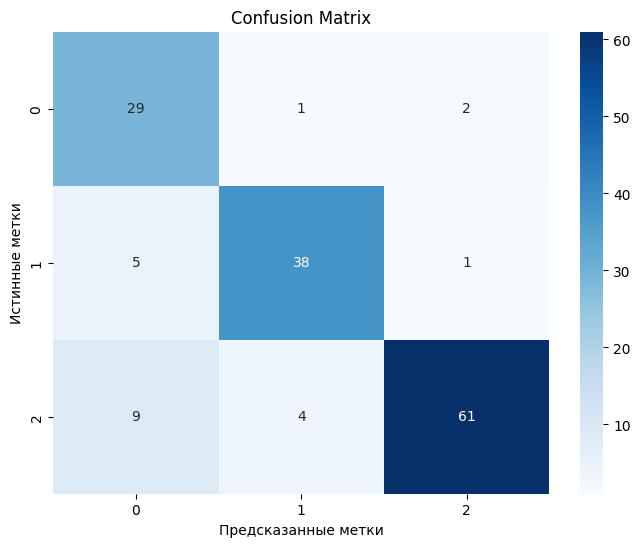


Classification Report:
              precision    recall  f1-score   support

           0      0.674     0.906     0.773        32
           1      0.884     0.864     0.874        44
           2      0.953     0.824     0.884        74

    accuracy                          0.853       150
   macro avg      0.837     0.865     0.844       150
weighted avg      0.873     0.853     0.857       150


Macro F1-score: 0.844
Weighted F1-score: 0.857

Детали по классам:
Класс 0: Precision=0.674,Recall=0.906, F1=0.773, Support=32
Класс 1: Precision=0.884,Recall=0.864, F1=0.874, Support=44
Класс 2: Precision=0.953,Recall=0.824, F1=0.884, Support=74


In [41]:
print('Обзор метрик на валидационной выборке:\n')
y_true = df_val['Заявка-Вопрос-Жалоба']
y_pred = predict_in_bulk2(df_val['Описание'].tolist())
show_metrics(y_true, y_pred)

Обзор метрик на тестовой выборке:

Confusion Matrix:
[[26  2  3]
 [ 2 34  2]
 [20  9 52]]


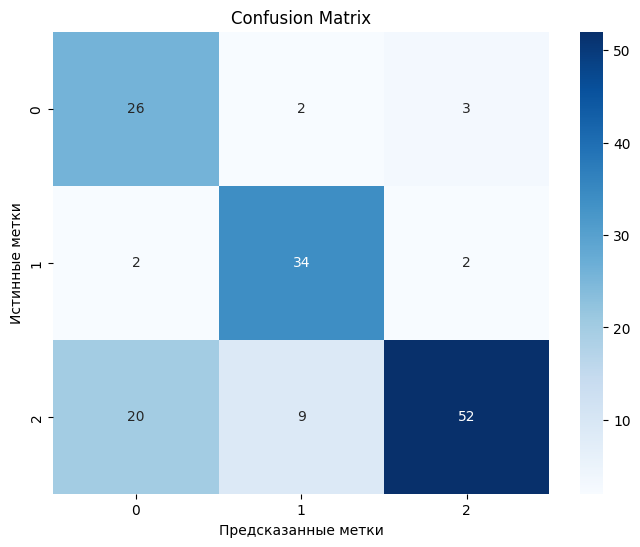


Classification Report:
              precision    recall  f1-score   support

           0      0.542     0.839     0.658        31
           1      0.756     0.895     0.819        38
           2      0.912     0.642     0.754        81

    accuracy                          0.747       150
   macro avg      0.737     0.792     0.744       150
weighted avg      0.796     0.747     0.751       150


Macro F1-score: 0.744
Weighted F1-score: 0.751

Детали по классам:
Класс 0: Precision=0.542,Recall=0.839, F1=0.658, Support=31
Класс 1: Precision=0.756,Recall=0.895, F1=0.819, Support=38
Класс 2: Precision=0.912,Recall=0.642, F1=0.754, Support=81


In [42]:
print('Обзор метрик на тестовой выборке:\n')
y_true = df_test['Заявка-Вопрос-Жалоба']
y_pred = predict_in_bulk2(df_test['Описание'].tolist())
show_metrics(y_true, y_pred)

### Отработка на всем датасете

In [51]:
# Здесь можено менять адрес датасета, и тогда модель обработает заданный файл
df_path = "/content/drive/MyDrive/drafts/hack_12_2025/обращения_predict.csv"
df = pd.read_csv(df_path)
texts = df['Описание'].tolist()

In [53]:
# Сохраняем файл с предсказаниями модели
df['Вид обращения'] = predict_in_bulk2(texts)
df.to_csv('обращения_predict2.csv',
          index=None
          )

### Fine